Execute this Notebook to generate three files inside the folder: train.csv, test.csv, definition.txt

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))

def sample_cat(p, soft=False, levels=False, rs=None, dtype=bool):
    flatten = len(p.shape) == 1
    if flatten:
        p = np.expand_dims(p, 1)
    if p.shape[1] == 1:
        p = np.concatenate([1 - p, p], 1)
    
    if rs is None:
        rs = np.random
        
    u = rs.uniform(size=p.shape)
    gumbel = -np.log(-np.log(u))
    
    score = np.log(p) + gumbel
    if soft:
        # Note that if soft, we can't return levels
        M = score.max(1, keepdim=True)
        log_x = score - (np.log(np.exp(score - M).sum(1)) + M)
        
        x = np.exp(log_x)
    else:
        argmax = np.argmax(score, 1)
        
        if levels:
            x = np.array(levels)[argmax]
        else:
            argmax = np.expand_dims(argmax, 1)
            x = np.expand_dims(np.arange(p.shape[1]), 0).repeat(len(p), 0) == argmax
        
    if levels and not soft:
        return x # already with the right shape
    else:
        x = x.astype(dtype)
        
        if flatten:
            x = x[:, 1]
        
        return x

In [3]:
N = 10000
rs = np.random.RandomState(seed=123)

experience = rs.exponential(size=N)
interests = rs.normal(size=N)

gender = rs.choice(range(2), replace=True, size=N, p=[.7, .3]).astype(bool)
age = rs.chisquare(10, size=N) * 2 + 16
_age_cdf = (np.expand_dims(age, 1) >= np.expand_dims(age, 0)).mean(1)

education = (np.sqrt(_age_cdf) * 2 - 1) + (-1 + .75 * rs.normal(size=N))
education = sigmoid(education)

_field_p = sigmoid(interests + (gender * 2 - 1) * 1.75)
_field_p = np.stack([_field_p, (1 - _field_p) / 2, (1 - _field_p) / 2], 1)
field = sample_cat(_field_p, rs=rs, dtype=bool)

seniority = np.log(1 + 
    (1 + experience) * 
    (1 + education) * 
    (1 + gender * .25) ** 2 * 
    #  (1 - (1 - field) * .25) *
    (field[:, 0] * 1 + field[:, 1] * .75 + field[:, 2] * .5) *
    (1 + _age_cdf ** 2)
)

salary = np.sqrt(education) * \
    np.sqrt(seniority) * \
    (.75 * field[:, 0] + .5 * field[:, 1] + .25 * field[:, 2])
    # (.75 * field + .5 * (1 - field))
salary = salary / salary.mean() * 10000 + 20000

# This will be used to filter out some individuals. 
# This generates a latent confounder via selection bias.
stay_at_home = (sample_cat(_age_cdf * .95 + .025, rs=rs) * (1 - gender)).astype(bool)

In [4]:
df = pd.DataFrame({
    'gender': gender,
    'field': field.argmax(1).astype(str),
    'age': age,
    'education': education,
    'seniority': seniority,
    'salary': salary,
    
    'experience': experience,
    'interests': interests,
})

df = df[~stay_at_home].copy()

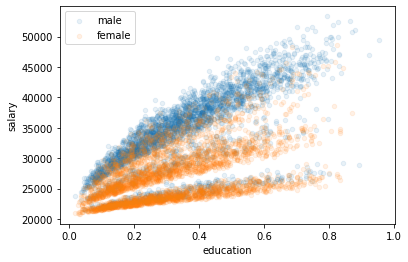

In [5]:
ax = df[df.gender].plot.scatter('education', 'salary', alpha=.1, color='C0', label='male')
df[~df.gender].plot.scatter('education', 'salary', alpha=.1, color='C1', ax=ax, label='female')
plt.legend()

In [6]:
df.corr()

,gender,age,education,seniority,salary,experience,interests
gender,1.000000,0.291469,0.126555,0.628254,0.571762,-0.012259,0.009384
age,0.291469,1.000000,0.475867,0.503632,0.466011,-0.024532,0.011544
education,0.126555,0.475867,1.000000,0.368217,0.585484,-0.018034,0.006635
seniority,0.628254,0.503632,0.368217,1.000000,0.820485,0.561744,0.103428
salary,0.571762,0.466011,0.585484,0.820485,1.000000,0.141660,0.182948
experience,-0.012259,-0.024532,-0.018034,0.561744,0.141660,1.000000,-0.003055
interests,0.009384,0.011544,0.006635,0.103428,0.182948,-0.003055,1.000000


<AxesSubplot:ylabel='Density'>

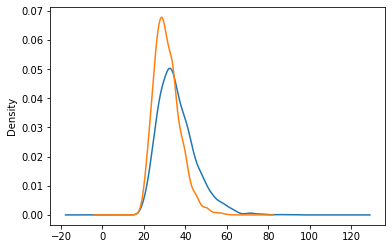

In [7]:
df[df.gender].age.plot.kde()
df[~df.gender].age.plot.kde()

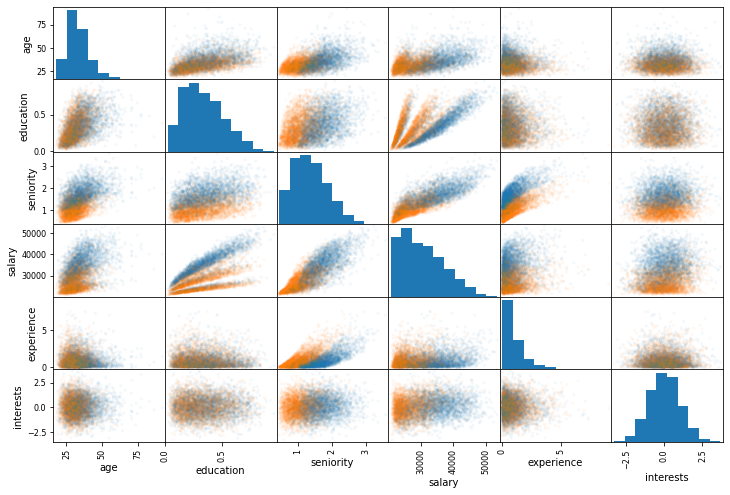

In [8]:
ax = pd.plotting.scatter_matrix(df.iloc[:, 2:], alpha=.05, figsize=(12, 8), c=np.array(['C0', 'C1'])[1 - df.gender]);

In [9]:
df.groupby('gender').salary.mean()

gender
False    27135.958406
True     34556.340154
Name: salary, dtype: float64

In [10]:
df.groupby(['gender', 'field']).size()

gender  field
False   0         649
        1        1444
        2        1428
True    0        2412
        1         279
        2         279
dtype: int64

In [11]:
df.groupby('gender').age.mean()

gender
False    31.211188
True     35.922745
Name: age, dtype: float64

In [12]:
df.gender.mean()

0.4575566168541057

<AxesSubplot:>

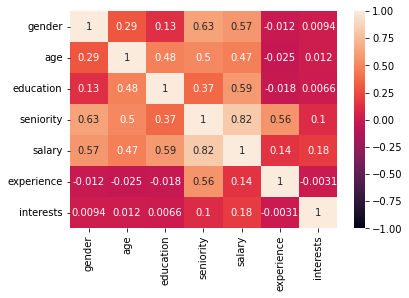

In [13]:
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)

In [14]:
# Drop both latents now: experience and interests
df = df.drop(['experience', 'interests'], 1)

In [15]:
df.head()

,gender,field,age,education,seniority,salary
1,False,2,28.167546,0.278197,0.635367,22915.529781
2,True,0,34.301064,0.419442,1.497411,36487.569950
3,False,1,29.023078,0.165927,0.979590,25591.650248
7,False,1,23.130233,0.488480,1.226342,30734.659278
9,True,1,36.458887,0.487854,1.508292,31897.254739


In [16]:
# Dummify field
df = pd.concat([
    df.loc[:, :'gender'],
    pd.get_dummies(df[['field']]),
    df.loc[:, 'age':]
], 1)

In [17]:
df.head()

,gender,field_0,field_1,field_2,age,education,seniority,salary
1,False,0,0,1,28.167546,0.278197,0.635367,22915.529781
2,True,1,0,0,34.301064,0.419442,1.497411,36487.569950
3,False,0,1,0,29.023078,0.165927,0.979590,25591.650248
7,False,0,1,0,23.130233,0.488480,1.226342,30734.659278
9,True,0,1,0,36.458887,0.487854,1.508292,31897.254739


In [18]:
definition = \
'''stay_at_home lat 1
gender bern 1 stay_at_home
field cat 3 gender
age cont 1 stay_at_home
education cont 1 age
seniority cont 1 age education gender field
salary cont 1 education seniority field
'''

In [19]:
split = .8

n = int(len(df) * split)
train, test = df.iloc[:n], df.iloc[n:]

In [20]:
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

with open('definition.txt', 'w') as f:
    f.write(definition)